# LLM zero-shot Evaluation

### Import necessary libraries for the evaluation
Import core libraries for API calls, data manipulation, metrics calculation, and model interaction.

In [1]:
import os
from urllib import response

import requests
# import pandas as pd
# from openai import OpenAI
# import anthropic
from pandas import DataFrame
from tqdm import tqdm
from ollama import Client
from enum import Enum
from sklearn.metrics import classification_report

### Check available local models
List all models available in the local Ollama installation to confirm which models can be used for testing.

In [2]:
!ollama list

NAME               ID              SIZE      MODIFIED    
qwen2.5:72b        424bad2cc13f    47 GB     9 days ago     
llama3.2:3b        a80c4f17acd5    2.0 GB    3 weeks ago    
llama3.1:8b        46e0c10c039e    4.9 GB    3 weeks ago    
llama3.3:latest    a6eb4748fd29    42 GB     5 weeks ago    
deepseek-r1:8b     28f8fd6cdc67    4.9 GB    5 weeks ago    
deepseek-r1:70b    0c1615a8ca32    42 GB     5 weeks ago    


### Basic prompt evaluation on noisy dataset
Run zero-shot classification using a simple prompt that asks for Yes/No answers on check-worthiness. Uses fallback logic for ambiguous responses.

In [8]:
import pandas as pd
noisy_test_100=pd.read_csv("random_multicw_test_100_noisy.csv")

In [18]:
import ollama

client=ollama.Client("http://localhost:11434")
# model_name="deepseek-r1:70b"
model_name="qwen2.5:72b"
answer={}
# for i in range(0, 10000):
# for i in range(0, 2000):
for i in range(0, len(noisy_test_100)):
    response=client.chat(
        # model="llama3.3:latest",
        model=model_name,
        # model="llama3.2:3b",
        messages=[
            ollama.Message(role="system", content=f"""You are a fact-checker assistant with a task to identify sentences that are check-worthy. Sentence is check-worthy only if it contains a verifiable factual claim and that claim can be harmful."""),
            ollama.Message(role="user", content=f"""
            Classify the check-worthiness of these sentences outputting only Yes or No:
            [{noisy_test_100.loc[i]['text']}] 
            do not display any explanations
    """)
            
            ]
    )
    if 'Yes' in response.message.content:
        answer[i]=1
    elif 'No' in response.message.content:
        answer[i]=0
    else:
        # Make a second attempt
        response = client.chat(
            model=model_name,
            messages=[
                ollama.Message(role="system", content=f"""Does it mean Yes or No? Answer strictly with Yes or No. 
                      If are unsure, answer with No."""),
                     ollama.Message(role="user", content=response.message.content)
            ]
            )
        if 'Yes' in response.message.content:
            answer[i]=1
        else:
            answer[i]=0
# print(response)
    print(response.message.content)
    # answer[i]=response.message.content
    ODP =pd.DataFrame({'answer': answer})
ODP.to_csv('res_qwen_noisy_100.csv', index=False)

No
No
Yes
No
No
Yes
Yes
No
No
Yes
Yes
Yes
No
Yes
No
Yes
Yes
Yes
Yes
No
No
Yes
Yes
No
Yes
No
Yes
Yes
No
Yes
No
Yes
No
Yes
Yes
No
No
No
Yes
No
No
No
No
Yes
Yes
Yes
No
No
Yes
Yes
Yes
No
No
No
No
No
No
No
No
No
No
No
No
Yes
Yes
No
No
No
Yes
Yes
No
No
Yes
Yes
No
No
No
Yes
No
Yes
No
Yes
No
No
No
Yes
No
No
No
Yes
Yes
Yes
Yes
Yes
No
Yes
Yes
Yes
Yes
No


### Basic prompt evaluation on structured dataset
Run the same zero-shot classification approach on the structured dataset to compare performance across different text types.

In [19]:
struct_test_100=pd.read_csv("random_multicw_test_100_struct.csv")

In [20]:
import ollama

client=ollama.Client("http://localhost:11434")
# model_name="deepseek-r1:70b"
model_name="qwen2.5:72b"
answer={}
# for i in range(0, 10000):
# for i in range(0, 2000):
for i in range(0, len(struct_test_100)):
    response=client.chat(
        # model="llama3.3:latest",
        model=model_name,
        # model="llama3.2:3b",
        messages=[
            ollama.Message(role="system", content=f"""You are a fact-checker assistant with a task to identify sentences that are check-worthy. Sentence is check-worthy only if it contains a verifiable factual claim and that claim can be harmful."""),
            ollama.Message(role="user", content=f"""
            Classify the check-worthiness of these sentences outputting only Yes or No:
            [{struct_test_100.loc[i]['text']}] 
            do not display any explanations
    """)
            
            ]
    )
    if 'Yes' in response.message.content:
        answer[i]=1
    elif 'No' in response.message.content:
        answer[i]=0
    else:
        # Make a second attempt
        response = client.chat(
            model=model_name,
            messages=[
                ollama.Message(role="system", content=f"""Does it mean Yes or No? Answer strictly with Yes or No. 
                      If are unsure, answer with No."""),
                     ollama.Message(role="user", content=response.message.content)
            ]
            )
        if 'Yes' in response.message.content:
            answer[i]=1
        else:
            answer[i]=0
# print(response)
    print(response.message.content)
    # answer[i]=response.message.content
    ODP =pd.DataFrame({'answer': answer})
ODP.to_csv('res_qwen_struct_100.csv', index=False)

No
Yes
No
Yes
Yes
No
Yes
Yes
Yes
No
No
No
No
No
No
No
Yes
No
No
No
No
No
No
No
No
No
No
Yes
Yes
No
No
Yes
Yes
No
No
Yes
No
No
Yes
No
No
No
No
Yes
Yes
No
Yes
No
No
No
No
Yes
No
Yes
No
Yes
Yes
Yes
No
Yes
Yes
No
No
Yes
No
Yes
No
No
No
No
No
Yes
No
No
No
Yes
No
Yes
No
No
No
No
Yes
No
No
No
Yes
No
Yes
No
No
Yes
No
No
Yes
Yes
No
Yes
Yes
No


### Guided Answer (GA) prompt experiments on noisy dataset
Attempt a simple prompting approach asking for likelihood assessment on a 1-5 scale, but this fails to produce proper Yes/No responses.

In [4]:
import pandas as pd
noisy_test_100=pd.read_csv("random_multicw_test_100_noisy.csv")

In [16]:
ODP.groupby('answer').value_counts()

answer
0    91
1     9
dtype: int64

In [17]:
import ollama

client=ollama.Client("http://localhost:11434")
# model_name="deepseek-r1:70b"
model_name="qwen2.5:72b"
answer={}
# for i in range(0, 10000):
# for i in range(0, 2000):
for i in range(0, len(noisy_test_100)):
    response=client.chat(
        # model="llama3.3:latest",
        model=model_name,
        # model="llama3.2:3b",
        messages=[
            ollama.Message(role="system", content=f"""You are a fact-checker assistant with a task to identify sentences that are check-worthy. Sentence is check-worthy only if it contains a verifiable factual claim and that claim can be harmful."""),
            ollama.Message(role="user", content=f"""
            Evaluating False Information Now, let's think about the likelihood of false information in the sentence. On a scale of 1-5, where 1 is "NO, definitely contains no false information" and 5 is "YES, definitely contains false information", what's our assessment?
[{noisy_test_100.loc[i]['text']}]
Your final answer is, do not display any explanations or intermediate steps:
    """)
            
            ]
    )
    if 'Yes' in response.message.content:
        answer[i]=1
    elif 'No' in response.message.content:
        answer[i]=0
    else:
        # Make a second attempt
        response = client.chat(
            model=model_name,
            messages=[
                ollama.Message(role="system", content=f"""Does it mean Yes or No? Answer strictly with Yes or No. 
                      If are unsure, answer with No."""),
                     ollama.Message(role="user", content=response.message.content)
            ]
            )
        if 'Yes' in response.message.content:
            answer[i]=1
        else:
            answer[i]=0
# print(response)
    print(response.message.content)
    # answer[i]=response.message.content
    ODP =pd.DataFrame({'answer': answer})
#ODP.to_csv('res_qwen_noisy_100_CoT_CLEF_new.csv', index=False)

No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No


### Guided Answer (GA) prompt experiments on structured dataset
A concise prompt instructing the model to act as a fact-checker and classify sentences strictly as Yes (check-worthy) or No (not check-worthy).

In [13]:
import ollama

client=ollama.Client("http://localhost:11434")
# model_name="deepseek-r1:70b"
model_name="qwen2.5:72b"
answer={}
# for i in range(0, 10000):
# for i in range(0, 2000):
for i in range(0, len(struct_test_100)):
    response=client.chat(
        # model="llama3.3:latest",
        model=model_name,
        # model="llama3.2:3b",
        messages=[
            ollama.Message(role="system", content=f"""You are a fact-checker assistant with a task to identify sentences that are check-worthy. Sentence is check-worthy only if it contains a verifiable factual claim and that claim can be harmful."""),
            ollama.Message(role="user", content=f"""Question: Classify if the sentence is check-worthy: They have a VAT tax.
Are follow up questions needed here: Yes
Follow up: Does the sentence contain a verifiable factual claim?
Intermediate answer: Yes
Follow up: Could the claim be considered a statement of opinion?
Intermediate answer: No
Follow up: What is the broad topic category of the claim?
Intermediate answer: Economy.
Follow up: Is the topic category sensitive?
Intermediate answer: Yes
Follow up : Can the claim be harmful if false?
Intermediate answer: Yes
So the final answer is: Yes

Question: Classify if the sentences below are check-worthy: [{struct_test_100.loc[i]['text']}]

Answer in binary Yes or No, do not display any explanations or intermediate steps.
    """)
            
            ]
    )
    if 'Yes' in response.message.content:
        answer[i]=1
    elif 'No' in response.message.content:
        answer[i]=0
    else:
        # Make a second attempt
        response = client.chat(
            model=model_name,
            messages=[
                ollama.Message(role="system", content=f"""Does it mean Yes or No? Answer strictly with Yes or No. 
                      If are unsure, answer with No."""),
                     ollama.Message(role="user", content=response.message.content)
            ]
            )
        if 'Yes' in response.message.content:
            answer[i]=1
        else:
            answer[i]=0
# print(response)
    print(response.message.content)
    # answer[i]=response.message.content
    ODP =pd.DataFrame({'answer': answer})
ODP.to_csv('res_qwen_struct_100_HCoT.csv', index=False)

Yes
Yes
No
Yes
Yes
No
Yes
Yes
Yes
No
No
Yes
Yes
No
Yes
No
Yes
No
Yes
Yes
Yes
No
No
Yes
Yes
Yes
Yes
Yes
Yes
No
No
Yes
Yes
Yes
Yes
Yes
Yes
No
Yes
Yes
No
Yes
Yes
Yes
Yes
No
Yes
Yes
No
Yes
No
Yes
Yes
Yes
Yes
Yes
Yes
Yes
Yes
Yes
Yes
No
No
Yes
Yes
Yes
Yes
No
Yes
No
Yes
Yes
Yes
Yes
Yes
Yes
Yes
Yes
No
Yes
Yes
No
Yes
No
No
Yes
Yes
Yes
Yes
No
Yes
Yes
Yes
Yes
Yes
Yes
Yes
Yes
Yes
Yes


### Chain-of-thought (CoT) prompting on noisy dataset
A refined CoT prompt with multi-scale evaluation (likelihood of falsehood, public interest, potential harm, all rated on a 1–5 scale) followed by a final binary decision claim vs. non-claim). 

In [18]:
import ollama

client=ollama.Client("http://localhost:11434")
# model_name="deepseek-r1:70b"
model_name="qwen2.5:72b"
answer={}
# for i in range(0, 10000):
# for i in range(0, 2000):
for i in range(0, len(noisy_test_100)):
    response=client.chat(
        # model="llama3.3:latest",
        model=model_name,
        # model="llama3.2:3b",
        messages=[
            ollama.Message(role="system", content=f"""You are a fact-checker assistant with a task to identify sentences that are check-worthy. Sentence is check-worthy only if it contains a verifiable factual claim and that claim can be harmful."""),
            ollama.Message(role="user", content=f"""Step 1: Check-worthiness of sentences. Sentences are in 16 different natural languages. We need to determine if the sentences contain a claim that a professional fact-checker should verify. To do this, we'll consider whether the claim is likely to be false, is of public interest, and/or appears to be harmful. What are our thoughts on this?
Step 2: Evaluating False Information Now, let's think about the likelihood of false information in the sentence. On a scale of 1-5, where 1 is "NO, definitely contains no false information" and 5 is "YES, definitely contains false information", what's our assessment?
Step 3: Considering Public Interest Next, we need to evaluate whether the sentence's claim has an impact on or is of interest to the general public. Using the same 1-5 scale, where 1 is "NO, definitely not of interest" and 5 is "YES, definitely of interest", what do we think?
Step 4: Assessing Harmfulness Now, let's consider the potential harm caused by the sentence. On the same 1-5 scale, where 1 is "NO, definitely not harmful" and 5 is "YES, definitely harmful", what's our evaluation?
Step 5: Conclusion Taking into account our thoughts from the previous steps, do we think the sentence is a "claim" that requires verification or a "non-claim" that doesn't require further investigation?
[{noisy_test_100.loc[i]['text']}] 
Our final answer is, do not display any explanations or intermediate steps:
    """)
            
            ]
    )
    if 'Yes' in response.message.content:
        answer[i]=1
    elif 'No' in response.message.content:
        answer[i]=0
    else:
        # Make a second attempt
        response = client.chat(
            model=model_name,
            messages=[
                ollama.Message(role="system", content=f"""Does it mean Yes or No? Answer strictly with Yes or No. 
                      If are unsure, answer with No."""),
                     ollama.Message(role="user", content=response.message.content)
            ]
            )
        if 'Yes' in response.message.content:
            answer[i]=1
        else:
            answer[i]=0
# print(response)
    print(response.message.content)
    # answer[i]=response.message.content
    ODP =pd.DataFrame({'answer': answer})
ODP.to_csv('res_qwen_noisy_100_CoT_CLEF_new.csv', index=False)

No
No
No
No
Non-claim
No
No
Non-claim
Non-claim
No
No
No
No
No
No
No
No
No
No
No
Non-claim
No
No
Non-claim
Non-claim
Non-claim
No
No
No
No
Non-claim
No
No
No
No
No
Non-claim
Non-claim
No
No
Non-claim
No
Non-claim
No
No
No
Non-claim
Non-claim
No
No
No
No
No
Non-claim
No
No
Non-claim
Non-claim
No
No
No
No
No
No
No
No
No
Non-claim
No
No
Non-claim
Non-claim
No
No
No
非 claim

However, it seems there was a misunderstanding in your request. The sentence provided "[首先，我们必须确定原点和任务部分是否是问题。]" translates to "First, we must determine whether the origin and task section is a question." This sentence does not contain a factual claim that can be verified or that has any potential harm or public interest. Therefore, it is not check-worthy.

For the structured evaluation you requested:
Step 1: The sentence does not contain a verifiable factual claim.
Step 2: Likelihood of false information: 1
Step 3: Public interest: 1
Step 4: Harmfulness: 1
Step 5: Conclusion: Non-claim

If you have another specific se

### Chain-of-thought prompting on structured dataset
A variant of the CLEF-inspired CoT, emphasizing multilingual robustness. 
It explicitly instructs the model to consider claims across 16 languages and judge check-worthiness based on falsehood likelihood, public interest, and harmfulness, before issuing a binary label. Apply the same 5-step chain-of-thought approach to the structured dataset to compare performance across text types.

In [19]:
struct_test_100=pd.read_csv("random_multicw_test_100_struct.csv")

In [20]:
import ollama

client=ollama.Client("http://localhost:11434")
# model_name="deepseek-r1:70b"
model_name="qwen2.5:72b"
answer={}
# for i in range(0, 10000):
# for i in range(0, 2000):
for i in range(0, len(struct_test_100)):
    response=client.chat(
        # model="llama3.3:latest",
        model=model_name,
        # model="llama3.2:3b",
        messages=[
            ollama.Message(role="system", content=f"""You are a fact-checker assistant with a task to identify sentences that are check-worthy. Sentence is check-worthy only if it contains a verifiable factual claim and that claim can be harmful."""),
            ollama.Message(role="user", content=f"""Step 1: Check-worthiness of sentences. Sentences are in 16 different natural languages. We need to determine if the sentences contain a claim that a professional fact-checker should verify. To do this, we'll consider whether the claim is likely to be false, is of public interest, and/or appears to be harmful. What are our thoughts on this?
Step 2: Evaluating False Information Now, let's think about the likelihood of false information in the sentence. On a scale of 1-5, where 1 is "NO, definitely contains no false information" and 5 is "YES, definitely contains false information", what's our assessment?
Step 3: Considering Public Interest Next, we need to evaluate whether the sentence's claim has an impact on or is of interest to the general public. Using the same 1-5 scale, where 1 is "NO, definitely not of interest" and 5 is "YES, definitely of interest", what do we think?
Step 4: Assessing Harmfulness Now, let's consider the potential harm caused by the sentence. On the same 1-5 scale, where 1 is "NO, definitely not harmful" and 5 is "YES, definitely harmful", what's our evaluation?
Step 5: Conclusion Taking into account our thoughts from the previous steps, do we think the sentence is a "claim" that requires verification or a "non-claim" that doesn't require further investigation?
[{struct_test_100.loc[i]['text']}] 
Our final answer is, do not display any explanations or intermediate steps:
    """)
            
            ]
    )
    if 'Yes' in response.message.content:
        answer[i]=1
    elif 'No' in response.message.content:
        answer[i]=0
    else:
        # Make a second attempt
        response = client.chat(
            model=model_name,
            messages=[
                ollama.Message(role="system", content=f"""Does it mean Yes or No? Answer strictly with Yes or No. 
                      If are unsure, answer with No."""),
                     ollama.Message(role="user", content=response.message.content)
            ]
            )
        if 'Yes' in response.message.content:
            answer[i]=1
        else:
            answer[i]=0
# print(response)
    print(response.message.content)
    # answer[i]=response.message.content
    ODP =pd.DataFrame({'answer': answer})
ODP.to_csv('res_qwen_struct_100_CoT_CLEF_new.csv', index=False)

No
No
Non-claim
No
No
No
No
No
No
No
Non-claim
No
Non-claim
Non-claim
Non-claim
No
No
Non-claim
Non-claim
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
Non-claim
No
No
No
No
No
No
No
Non-claim
Non-claim
No
No
No
No
Non-claim
No
No
No
Non-claim
No
No
No
No
No
Non-claim
No
No
Non-claim
No
No
Non-claim
No
No
Non-claim
No
No
No
No
No
No
No
Non-claim
No
No
No
No
No
Non-claim
No
No
No
No
No
Non-claim
No
No
No
No
No
No


### Hybrid Chain-of-thoughts prompting: 
A hybrid prompt combining guided sub-questions and reasoning steps (e.g., verifiability, opinion vs. fact, sensitivity of topic, harmfulness) with a final Yes/No classification. 

In [14]:
import ollama

client=ollama.Client("http://localhost:11434")
# model_name="deepseek-r1:70b"
model_name="qwen2.5:72b"
answer={}
# for i in range(0, 10000):
# for i in range(0, 2000):
for i in range(0, len(noisy_test_100)):
    response=client.chat(
        # model="llama3.3:latest",
        model=model_name,
        # model="llama3.2:3b",
        messages=[
            ollama.Message(role="system", content=f"""You are a fact-checker assistant with a task to identify sentences that are check-worthy. Sentence is check-worthy only if it contains a verifiable factual claim and that claim can be harmful."""),
            ollama.Message(role="user", content=f"""Question: Classify if the sentence is check-worthy: They have a VAT tax.
Are follow up questions needed here: Yes
Follow up: Does the sentence contain a verifiable factual claim?
Intermediate answer: Yes
Follow up: Could the claim be considered a statement of opinion?
Intermediate answer: No
Follow up: What is the broad topic category of the claim?
Intermediate answer: Economy.
Follow up: Is the topic category sensitive?
Intermediate answer: Yes
Follow up : Can the claim be harmful if false?
Intermediate answer: Yes
So the final answer is: Yes

Question: Classify if the sentences below are check-worthy: [{noisy_test_100.loc[i]['text']}]

Answer in binary Yes or No, do not display any explanations or intermediate steps.
    """)
            
            ]
    )
    if 'Yes' in response.message.content:
        answer[i]=1
    elif 'No' in response.message.content:
        answer[i]=0
    else:
        # Make a second attempt
        response = client.chat(
            model=model_name,
            messages=[
                ollama.Message(role="system", content=f"""Does it mean Yes or No? Answer strictly with Yes or No. 
                      If are unsure, answer with No."""),
                     ollama.Message(role="user", content=response.message.content)
            ]
            )
        if 'Yes' in response.message.content:
            answer[i]=1
        else:
            answer[i]=0
# print(response)
    print(response.message.content)
    # answer[i]=response.message.content
    ODP =pd.DataFrame({'answer': answer})
ODP.to_csv('res_qwen_noisy_100_HCoT.csv', index=False)

Yes
No
Yes
No
Yes
Yes
Yes
Yes
No
Yes
Yes
Yes
Yes
Yes
Yes
Yes
Yes
Yes
Yes
No
No
Yes
Yes
No
Yes
No
Yes
Yes
Yes
Yes
No
Yes
Yes
Yes
Yes
Yes
No
Yes
Yes
No
No
Yes
No
Yes
Yes
Yes
No
Yes
Yes
Yes
Yes
No
Yes
No
Yes
No
No
No
Yes
No
No
Yes
Yes
Yes
Yes
Yes
Yes
No
Yes
Yes
No
No
Yes
Yes
No
No
Yes
Yes
No
Yes
No
Yes
No
Yes
Yes
Yes
No
No
No
Yes
Yes
Yes
Yes
Yes
No
Yes
Yes
Yes
Yes
No


### Generate confusion matrices for basic prompting results
Create and save confusion matrix visualizations for the basic prompting approach across different models and datasets.

In [37]:
import pandas as pd
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn import metrics
import matplotlib.pyplot as plt

df_noisy = pd.read_csv('random_multicw_test_100_noisy.csv')
df_struct = pd.read_csv('random_multicw_test_100_struct.csv')

In [38]:
struct_orig = df_orig['label'].astype('int')
noisy_orig = df_noisy['label'].astype('int')

ACC
res_llama_noisy_100
res_llama_struct_100
res_qwen_noisy_100
res_qwen_struct_100


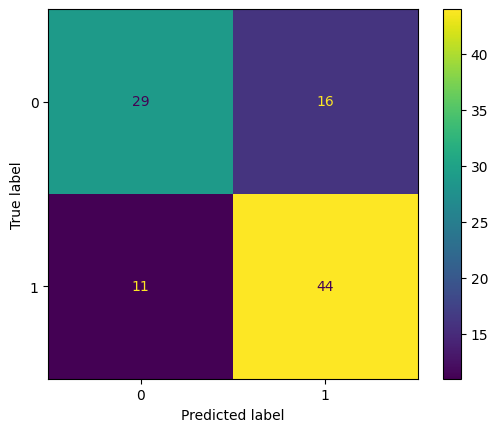

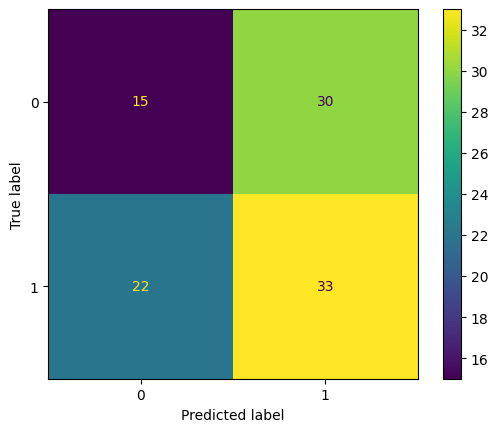

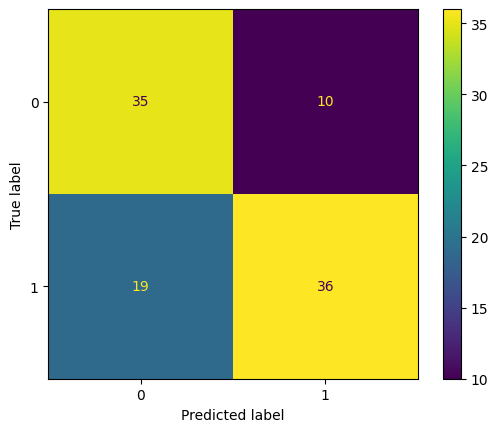

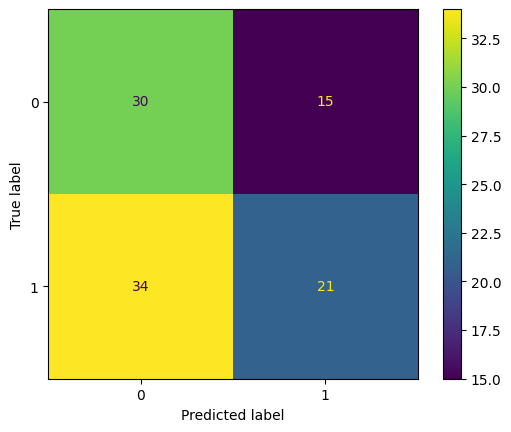

In [48]:
names = ['res_llama_noisy_100', 'res_llama_struct_100', 'res_qwen_noisy_100', 'res_qwen_struct_100']

print("ACC")
for name in names:
    print(name)
    df_res = pd.read_csv('prompt_res/' + name + '.csv')
    res_pred = df_res['answer']
    if 'struct' in name:
        confusion_matrix = metrics.confusion_matrix(struct_orig, res_pred)
        cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [0, 1])
        cm_display.plot()
        #plt.show()
        plt.savefig('prompt_res/img/'+name+'.png')
        #print('{}'.format(accuracy_score(struct_orig, res_pred)*100))
    else:
        confusion_matrix = metrics.confusion_matrix(noisy_orig, res_pred)
        cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [0, 1])
        cm_display.plot()
        #plt.show()
        plt.savefig('prompt_res/img/'+name+'.png')

### Generate confusion matrices for CoT prompting results
Create confusion matrix visualizations for the chain-of-thought prompting approach results.

res_llama_noisy_100_CoT_CLEF_new
res_llama_struct_100_CoT_CLEF_new
res_qwen_noisy_100_CoT_CLEF_new
res_qwen_struct_100_CoT_CLEF_new


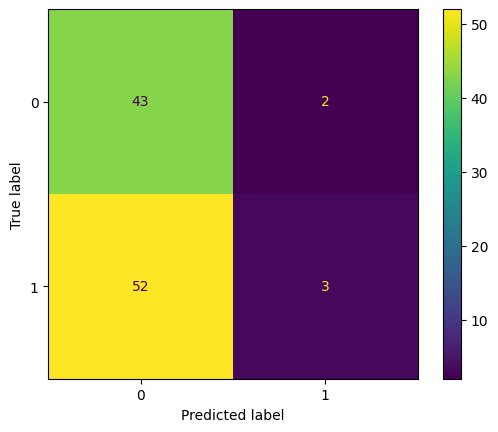

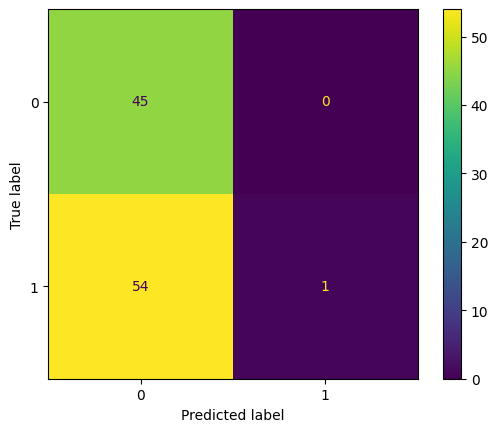

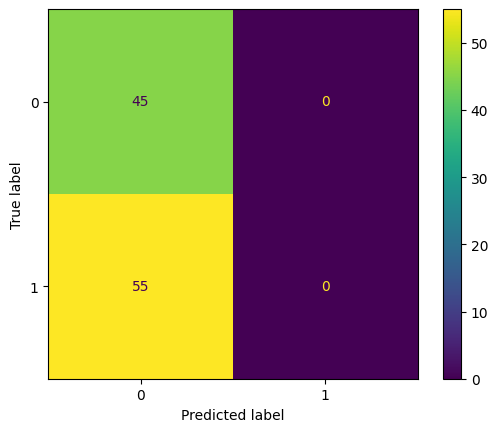

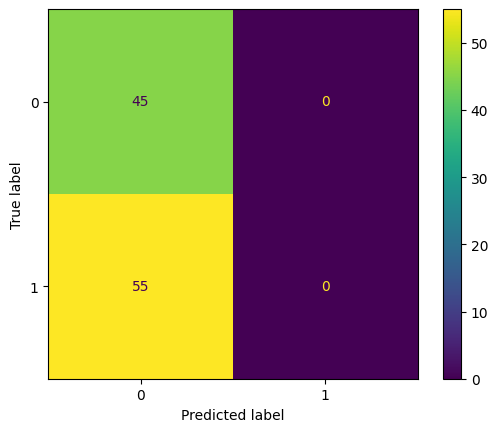

In [47]:
names = ['res_llama_noisy_100_CoT_CLEF_new', 'res_llama_struct_100_CoT_CLEF_new', 'res_qwen_noisy_100_CoT_CLEF_new', 'res_qwen_struct_100_CoT_CLEF_new']

for name in names:
    print(name)
    df_res = pd.read_csv('prompt_res/' + name + '.csv')
    res_pred = df_res['answer']
    if 'struct' in name:
        confusion_matrix = metrics.confusion_matrix(struct_orig, res_pred)
        cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [0, 1])
        cm_display.plot()
        #plt.show()
        plt.savefig('prompt_res/img/'+name+'.png')
        #print('{}'.format(accuracy_score(struct_orig, res_pred)*100))
    else:
        confusion_matrix = metrics.confusion_matrix(noisy_orig, res_pred)
        cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [0, 1])
        cm_display.plot()
        #plt.show()
        plt.savefig('prompt_res/img/'+name+'.png')

### Generate confusion matrices for human-guided CoT results
Create confusion matrix visualizations for the human-guided chain-of-thought prompting approach results.

res_llama_noisy_100_HCoT
res_llama_struct_100_HCoT
res_qwen_noisy_100_HCoT
res_qwen_struct_100_HCoT


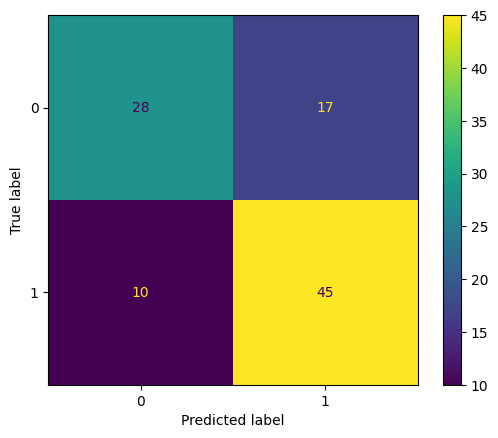

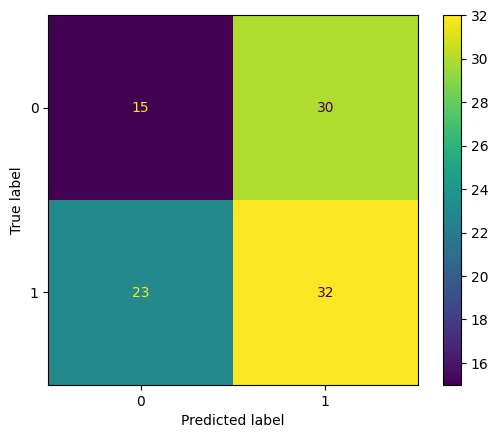

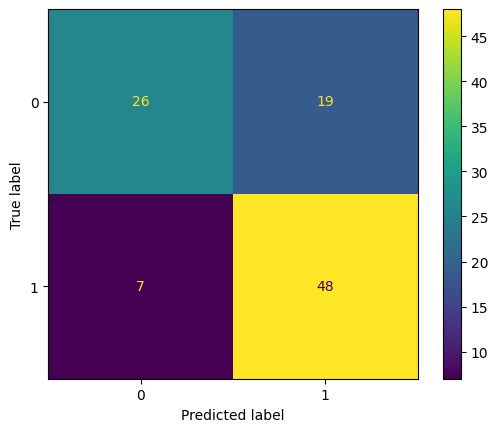

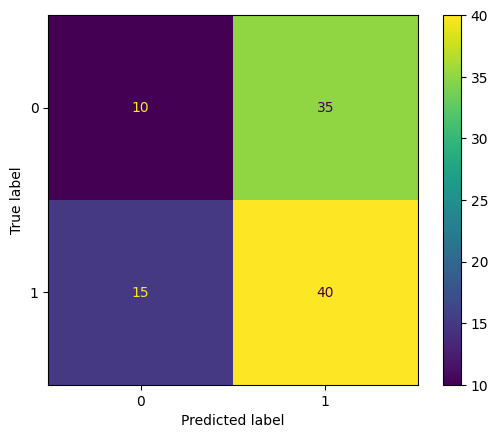

In [46]:
names = ['res_llama_noisy_100_HCoT', 'res_llama_struct_100_HCoT', 'res_qwen_noisy_100_HCoT', 'res_qwen_struct_100_HCoT']

for name in names:
    print(name)
    df_res = pd.read_csv('prompt_res/' + name + '.csv')
    res_pred = df_res['answer']
    if 'struct' in name:
        confusion_matrix = metrics.confusion_matrix(struct_orig, res_pred)
        cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [0, 1])
        cm_display.plot()
        #plt.show()
        plt.savefig('prompt_res/img/'+name+'.png')
        #print('{}'.format(accuracy_score(struct_orig, res_pred)*100))
    else:
        confusion_matrix = metrics.confusion_matrix(noisy_orig, res_pred)
        cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [0, 1])
        cm_display.plot()
        #plt.show()
        plt.savefig('prompt_res/img/'+name+'.png')